# Load a detectron2 model

In [199]:
import os
import cv2
import numpy as np
import geopandas as gpd
from shapely.geometry import Polygon
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2 import model_zoo
from colorama import Fore

from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.data import MetadataCatalog
import cv2
import numpy as np
from matplotlib import pyplot as plt
from matplotlib.backends.backend_agg import FigureCanvasAgg as FigureCanvas
from detectron2.utils.visualizer import Visualizer
from detectron2.utils.visualizer import ColorMode

import logging
import json
from pathlib import Path
from PIL import Image

def read_dict_from_file(file_path):
    with open(file_path, 'r') as file:
        data = file.read()
        dictionary = json.loads(data)
    return dictionary

def get_value_from_dict(file_path, key):
    dictionary = read_dict_from_file(file_path)
    return dictionary.get(key, None)

def add_key_value_to_dict(file_path, key, value):
    dictionary = read_dict_from_file(file_path)
    dictionary[key] = value
    with open(file_path, 'w') as file:
        json.dump(dictionary, file, indent=4)
        
model_name = "craters_22"

# (1) Set up the model and predictor (replace with your own config/model)
for i in [1, 2]:
    try:
        MetadataCatalog.get(model_name).thing_classes
    except Exception as e:
        print(Fore.RED + f"WARNING: An error occured retrieving labels for {model_name}. This may be an issue with detectrons training process. Try running 'MetadataCatalog.get({model_name}).set(thing_classes=[array of classes for this dataset])'. ...Trying a workaround with local dataloaders... \n\n" + Fore.WHITE)
        MetadataCatalog.get(model_name).set(thing_classes=get_value_from_dict('/Users/coltenrodriguez/Downloads/PixLab-main2/MLtools/LoadModelMetadata.txt' , model_name))
        continue

# Configure the model for inference
cfg = get_cfg()
cfg.merge_from_file("/Users/coltenrodriguez/Downloads/PixLab-main2/output" + "/" + model_name + "_config.yaml")
cfg.MODEL.WEIGHTS = "/Users/coltenrodriguez/Downloads/PixLab-main2/output" + "/" + model_name + ".pth"  # Load the saved model
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.5  # Set the testing threshold for this model
predictor = DefaultPredictor(cfg)

def classify(image, j):
    outputs = predictor(image)
    masks = outputs["instances"].pred_masks.cpu().numpy()
    classes = outputs["instances"].pred_classes.cpu().numpy()

    # (3) Convert masks to polygons
    geoms = []
    for i, mask in enumerate(masks):
        contours, _ = cv2.findContours(mask.astype(np.uint8), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        for contour in contours:
            if len(contour) >= 3:  # Must have at least 3 points for a polygon
                polygon = Polygon([tuple(pt[0]) for pt in contour])
                if polygon.is_valid:
                    geoms.append({"geometry": polygon, "class_id": int(classes[i])})

    # (4) Create GeoDataFrame
    wkt = 'PROJCRS["SimpleCylindrical Mars",BASEGEOGCRS["GCS_Mars",DATUM["D_Mars",ELLIPSOID["Mars",3396190,0,LENGTHUNIT["metre",1,ID["EPSG",9001]]]],PRIMEM["Reference_Meridian",0,ANGLEUNIT["degree",0.0174532925199433,ID["EPSG",9122]]]],CONVERSION["Equidistant Cylindrical",METHOD["Equidistant Cylindrical",ID["EPSG",1028]],PARAMETER["Latitude of 1st standard parallel",0,ANGLEUNIT["degree",0.0174532925199433],ID["EPSG",8823]],PARAMETER["Longitude of natural origin",180,ANGLEUNIT["degree",0.0174532925199433],ID["EPSG",8802]],PARAMETER["False easting",0,LENGTHUNIT["metre",1],ID["EPSG",8806]],PARAMETER["False northing",0,LENGTHUNIT["metre",1],ID["EPSG",8807]]],CS[Cartesian,2],AXIS["easting",east,ORDER[1],LENGTHUNIT["metre",1,ID["EPSG",9001]]],AXIS["northing",north,ORDER[2],LENGTHUNIT["metre",1,ID["EPSG",9001]]]]'
    gdf = gpd.GeoDataFrame(geoms, crs=wkt)  # Replace CRS with your actual image's CRS if known

    # (5) Save to shapefile
    shapefile_path = "/Volumes/LaCie/shp_tiles/" + str(j) + ".shp"
    os.makedirs(os.path.dirname(shapefile_path), exist_ok=True)
    gdf.to_file(shapefile_path)

    print(f"Shapefile {i} saved to {shapefile_path}")



# Make predictions on a region of image

In [196]:
import rasterio
import geopandas as gpd
from rasterio.mask import mask
import matplotlib.pyplot as plt
import os
import pandas as pd

def stitch_tiles_grid(tile_folder, n_rows, n_cols, output_path):
    """
    Combines n_rows x n_cols shapefiles from a tile folder into one shapefile,
    preserving spatial layout.

    Assumes tile files are named 0.shp to (n*m - 1).shp in row-major order.

    Parameters:
        tile_folder (str): Path to folder with shapefiles (named 0.shp to n*m-1.shp)
        n_rows (int): Number of rows in tile grid
        n_cols (int): Number of columns in tile grid
        output_path (str): Path to output stitched shapefile
    """
    gdfs = []
    
    for i in range(n_rows * n_cols):
        shp_path = os.path.join(tile_folder, f"{i}.shp")
        if not os.path.exists(shp_path):
            raise FileNotFoundError(f"Tile {i}.shp not found in {tile_folder}")

        gdf = gpd.read_file(shp_path)
        gdf["tile_id"] = i
        gdf["row"] = i // n_cols
        gdf["col"] = i % n_cols
        gdfs.append(gdf)

    stitched_gdf = gpd.GeoDataFrame(pd.concat(gdfs, ignore_index=True), crs=gdfs[0].crs)

    # Save the stitched shapefile (features maintain original position)
    stitched_gdf.to_file(output_path)

    return stitched_gdf


def clip_im_from_extent(image_path, shapefile_path):
    # Load shapefile
    shapefile = gpd.read_file(shapefile_path)
    # shapefile = shapefile.to_crs("EPSG:4326")  # Match CRS if needed

    # Open the georeferenced image
    with rasterio.open(image_path) as src:
        # Reproject shapefile to image CRS
        print(src.crs)
        shapefile = shapefile.to_crs(src.crs)

        # Get geometry from shapefile
        geometries = [feature["geometry"] for feature in shapefile.__geo_interface__["features"]]

        # Clip the image using the shapefile geometry
        clipped_image, clipped_transform = mask(src, geometries, crop=True)
        clipped_meta = src.meta.copy()
        clipped_meta.update({
            "height": clipped_image.shape[1],
            "width": clipped_image.shape[2],
            "transform": clipped_transform
        })

    return clipped_image[:3].transpose(1, 2, 0)

def splice_ims_to_detect(im):
    def get_ref_dims():
        model_ref_pth = "/Users/coltenrodriguez/Downloads/Craters_detectron_/craters_21/train"
        return [cv2.imread(model_ref_pth + "/" +file).shape for file in os.listdir(model_ref_pth) if ".png" in file][0]
    def split_extent_into_graticules(im, n, m):
        """Split extent geometry into n x n graticules."""
        minx, miny, maxx, maxy = extent_geom.bounds
        l, w = shape(extent_geom)
        width = (maxx - minx) / n
        height = (maxy - miny) / n

        graticules = []
        garticule_sizes = []
        for i in range(n):
            for j in range(n):
                cell = box(minx + i * width, miny + j * height,
                           minx + (i + 1) * width, miny + (j + 1) * height)
                graticules.append(cell)
                garticule_sizes.append(shape(cell))
        return graticules, garticule_sizes, height, width

    ref_height, ref_width, _ = get_ref_dims()
    height, width, _ = im.shape
    n, m = int(height/ref_height), int(width/ref_width) # ideal number of sub images to subprocess by detectron
    print(n, m)
    tile_h = height // n
    tile_w = width // m

    sub_images = []
    for i in range(n):
        for j in range(m):
            y0 = i * tile_h
            x0 = j * tile_w
            # Handle boundary tiles to avoid losing pixels due to integer division
            y1 = (i + 1) * tile_h if i < n - 1 else height
            x1 = (j + 1) * tile_w if j < m - 1 else width
            sub_image = im[y0:y1, x0:x1]
            # print(sub_image.shape)
            sub_images.append(sub_image)

    return sub_images

# Example usage
extent = "/Users/coltenrodriguez/Downloads/extent.shp"
image = "/Volumes/LaCie/Utopia_Planitia_Pics/U15_076957_2054_XN_25N250W_modified.tif"
image = "/Volumes/LaCie/Utopia_Planitia_Pics/G01_018789_2052_XI_25N250W_modified.tif"
image = "/Volumes/LaCie/Utopia_Planitia_Pics/G01_018789_2052_XI_25N250W_modified.tif"
image = "/Volumes/LaCie/Utopia_Planitia_Pics/U15_clipped.tif"
image = "/Volumes/LaCie/Utopia_Planitia_Pics/U15_076957_2054_XN_25N250W_modified.tif"
im = clip_im_from_extent(image, extent)
ims = splice_ims_to_detect(im)
print(f'{len(ims)} files')
for subimage, i in zip(ims, range(0, len(ims))):
    classify(np.flip(subimage, 0), i)



PROJCS["SimpleCylindrical Mars",GEOGCS["GCS_Mars",DATUM["D_Mars",SPHEROID["Mars",3396190,0]],PRIMEM["Reference_Meridian",0],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]]],PROJECTION["Equirectangular"],PARAMETER["standard_parallel_1",0],PARAMETER["central_meridian",180],PARAMETER["false_easting",0],PARAMETER["false_northing",0],UNIT["metre",1,AUTHORITY["EPSG","9001"]],AXIS["Easting",EAST],AXIS["Northing",NORTH]]
18 2
36 files
Shapefile 16 saved to /Volumes/LaCie/shp_tiles/0.shp
Shapefile 21 saved to /Volumes/LaCie/shp_tiles/1.shp
Shapefile 23 saved to /Volumes/LaCie/shp_tiles/2.shp
Shapefile 17 saved to /Volumes/LaCie/shp_tiles/3.shp
Shapefile 22 saved to /Volumes/LaCie/shp_tiles/4.shp
Shapefile 19 saved to /Volumes/LaCie/shp_tiles/5.shp
Shapefile 23 saved to /Volumes/LaCie/shp_tiles/6.shp
Shapefile 23 saved to /Volumes/LaCie/shp_tiles/7.shp
Shapefile 18 saved to /Volumes/LaCie/shp_tiles/8.shp
Shapefile 19 saved to /Volumes/LaCie/shp_tiles/9.shp
Shapefile 20 saved to /Volum

# Reprojecting, scaling and stitching the files

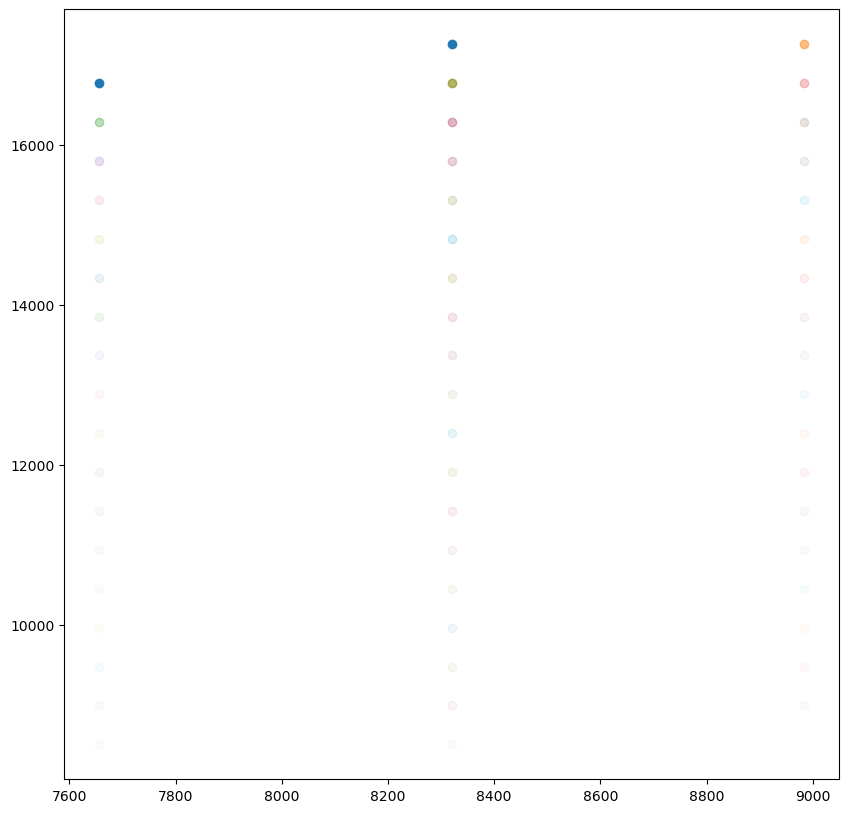

In [197]:
import geopandas as gpd
from shapely.geometry import box
from shapely.geometry import Point
from shapely.affinity import scale, translate
import geopandas as gpd

def merge_shapefiles(shapefile_paths, output_path):
    gdf_list = []
    for path in shapefile_paths:
        gdf = gpd.read_file(path)
        gdf_list.append(gdf)

    # Concatenate all GeoDataFrames
    merged_gdf = gpd.GeoDataFrame(pd.concat(gdf_list, ignore_index=True))

    # Ensure the CRS is consistent; assume all input files have the same CRS
    merged_gdf.set_crs(gdf_list[0].crs, inplace=True)

    # Save to a new shapefile
    merged_gdf.to_file(output_path)


def sort_files(files):
    return sorted(files, key=lambda x: int(os.path.splitext(os.path.basename(x))[0]))

def reproject_and_clip(input_shapefiles, reference_shapefile, n, m):
    def split_square(minx, miny, maxx, maxy, n_rows, n_cols):
        width = (maxx - minx) / n_cols
        height = (maxy - miny) / n_rows

        grid_cells = []
        for row in range(n_rows):
            for col in range(n_cols):
                cell_minx = minx + col * width
                cell_maxx = cell_minx + width
                cell_maxy = maxy - row * height
                cell_miny = cell_maxy - height
                grid_cells.append((cell_minx, cell_miny, cell_maxx, cell_maxy))

        fig = plt.figure(figsize=(10,10))
        for i, cell in enumerate(grid_cells):
            minx, miny, maxx, maxy = cell
            plt.scatter([minx, maxx], [miny, maxy], alpha=1/(i+1))
        return grid_cells

    # Load the shapefiles
    gdf_reference = gpd.read_file(reference_shapefile)
    minx, miny, maxx, maxy = gdf_reference.total_bounds
    grid_cell_coords = split_square(minx, miny, maxx, maxy, m, n)
        
    num = len(input_shapefiles)
    for i, f in enumerate(input_shapefiles):
        gdf_input = gpd.read_file(f)

        # Reproject the input shapefile to match the CRS of the reference shapefile
        gdf_input = gdf_input.to_crs(gdf_reference.crs)

        # Get the bounds of the reference shapefile
        minx, miny, maxx, maxy = grid_cell_coords[i]
        gdf_reproj = gdf_input.copy()
        # Scale the output
        minx_reproj, miny_reproj, maxx_reproj, maxy_reproj = gdf_reproj.total_bounds
        scale_x, scale_y = ((maxx-minx))/(maxx_reproj-minx_reproj), ((maxy-miny))/(maxy_reproj-miny_reproj)
        
        gdf_reproj['geometry'] = gdf_reproj['geometry'].apply(
            lambda geom: scale(geom, xfact=scale_x, yfact=scale_y, origin=(minx_reproj, miny_reproj))
        )
        
        minx_reproj, miny_reproj, maxx_reproj, maxy_reproj = gdf_reproj.total_bounds
        gdf_reproj['geometry'] = gdf_reproj['geometry'].apply(
            lambda geom: translate(geom, xoff=minx-minx_reproj, yoff=maxy-maxy_reproj)
        )

        gdf_reproj.to_file(f)



reproject_and_clip(sort_files(['/Volumes/LaCie/shp_tiles/'+f for f in os.listdir('/Volumes/LaCie/shp_tiles') if ".shp" in f]), "/Users/coltenrodriguez/Downloads/extent.shp", 2, 18)
merge_shapefiles(sort_files(['/Volumes/LaCie/shp_tiles/'+f for f in os.listdir('/Volumes/LaCie/shp_tiles') if ".shp" in f]), '/Volumes/LaCie/shp_tiles/predicted_craters5')

In [198]:
import geopandas as gpd
import os

def combine_shapefiles(shapefile_paths, output_path):
    """
    Combines multiple QGIS shapefiles into a single shapefile.

    Parameters:
        shapefile_paths (list of str): Paths to the input shapefiles.
        output_path (str): Path to the output combined shapefile.
    """
    # List to hold individual GeoDataFrames
    gdfs = []

    for path in shapefile_paths:
        if not os.path.exists(path):
            print(f"Warning: File not found - {path}")
            continue
        gdf = gpd.read_file(path)
        gdfs.append(gdf)

    if not gdfs:
        print("No valid shapefiles to combine.")
        return

    # Combine all GeoDataFrames
    combined_gdf = gpd.GeoDataFrame(pd.concat(gdfs, ignore_index=True), crs=gdfs[0].crs)

    # Write to output shapefile
    combined_gdf.to_file(output_path)

    print(f"Combined shapefile saved to: {output_path}")
combine_shapefiles(['/Volumes/LaCie/c/'+f for f in os.listdir('/Volumes/LaCie/c') if ".shp" in f], '/Volumes/LaCie/b/UPallcaters2.shp')

Combined shapefile saved to: /Volumes/LaCie/b/UPallcaters2.shp
